In [1]:
# -*- coding: utf-8 -*-
# Robust MLP pipeline with label cleaning (NaN + all-zero handling),
# target/one-hot auto-detection, feature alignment, focal loss, temp scaling.

import os, math, random, warnings
from pathlib import Path
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix,
                             f1_score, precision_recall_fscore_support,
                             accuracy_score)
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt
try:
    from tqdm import tqdm
except Exception:
    def tqdm(x, **k): return x

warnings.filterwarnings("ignore")

# ======================= CONFIG (defaults; can be overridden in Cell 2) =======================
INCLUDE_CALVING = True          # 6 classes with 'calving'; set False for 5 classes (calving rows removed)
PREFER_TARGET_COLUMN = True     # use df['target'] if valid (0..C-1)
ALL_ZERO_POLICY = "drop"        # 'drop' | 'map_to_ok' | 'error'
NAN_POLICY = "drop"             # 'drop' | 'error'

SEED = 42
VAL_SIZE = 0.15

HIDDEN_DIMS = [512, 256, 128]
DROPOUTS    = [0.5, 0.4, 0.3]
ACTIVATION  = 'leakyrelu'
USE_BN      = True

BATCH_SIZE   = 128
LR           = 5e-4
WEIGHT_DECAY = 1e-4
EPOCHS       = 200
PATIENCE     = 30
MIN_DELTA    = 1e-3
USE_FOCAL    = True
LEARN_TEMP   = True

# ======================= UTILS =======================
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def freeze_label_order(include_calving=True, custom_labels=None):
    """
    If custom_labels is provided, it will be used as-is to define class order.
    Otherwise, we fall back to legacy behavior (include_calving toggles 'calving').
    """
    if custom_labels is not None:
        label_cols = list(custom_labels)
    else:
        label_cols = ['oestrus','lameness','mastitis','other_disease','OK']
        if include_calving and 'calving' not in label_cols:
            label_cols.insert(1, 'calving')

    idx2name = {i: c for i, c in enumerate(label_cols)}
    name2idx = {c: i for i, c in enumerate(label_cols)}
    return label_cols, idx2name, name2idx


def optionally_drop_calving(df, include_calving: bool):
    df = df.copy()
    if include_calving:
        return df
    if 'calving' in df.columns:
        before = len(df)
        df = df[df['calving'] == 0].copy()
        print(f"[INFO] Removed {before-len(df)} rows with calving==1 for 5-class setup.")
    return df

def _validate_target_column(df, n_classes):
    if 'target' not in df.columns:
        return False
    col = df['target']
    if col.isna().any():
        return False
    vals = col.astype(float)
    if not np.all(np.isfinite(vals)): return False
    if not np.all(np.equal(vals, np.floor(vals))): return False
    vals = vals.astype(int)
    if (vals.min() < 0) or (vals.max() >= n_classes): return False
    return True

def _one_hot_sanity(df, label_cols):
    sub = df[label_cols].astype(float)
    row_sums = sub.sum(axis=1)
    bad_all_zero  = int((row_sums == 0).sum())
    bad_multi_hot = int((row_sums > 1.0 + 1e-9).sum())
    bad_nans      = int(sub.isna().any(axis=1).sum())
    dist = sub.idxmax(axis=1).value_counts(dropna=False).sort_index()
    return bad_all_zero, bad_multi_hot, bad_nans, dist

def extract_labels(df, label_cols, all_zero_policy="drop", nan_policy="drop", prefer_target=True):
    """
    Returns:
      y (np.ndarray[int]),
      df_clean (df after cleaning according to policies),
      info (dict)
    """
    df = df.copy()
    n_classes = len(label_cols)

    # Prefer integer target if valid
    if prefer_target and _validate_target_column(df, n_classes):
        y = df['target'].astype(int).values
        return y, df, {"used": "target"}

    # Else use one-hot
    for c in label_cols:
        if c not in df.columns:
            raise ValueError(f"Missing label column '{c}' in dataframe.")

    bad_zero, bad_multi, bad_nan, dist = _one_hot_sanity(df, label_cols)
    print("\n[One-hot distribution (argmax, raw)]")
    print(dist)
    print(f"[One-hot sanity] all_zero={bad_zero}, multi_hot={bad_multi}, any_nan={bad_nan}")

    if bad_multi > 0:
        raise ValueError("Labels must be strictly one-hot (found multi-hot rows). Please fix source data.")

    # Handle NaNs
    if bad_nan > 0:
        if nan_policy == "error":
            raise ValueError(f"Found {bad_nan} NaN in label columns. Set NAN_POLICY='drop' to drop those rows.")
        elif nan_policy == "drop":
            before = len(df)
            mask = ~df[label_cols].isna().any(axis=1)
            df = df.loc[mask].copy()
            print(f"[INFO] Dropped {before-len(df)} rows with NaN in label columns.")
        else:
            raise ValueError("NAN_POLICY must be 'drop' or 'error'.")

    # Recompute after NaN drop
    bad_zero, bad_multi, bad_nan, _ = _one_hot_sanity(df, label_cols)
    assert bad_multi == 0 and bad_nan == 0, "Internal: NaN/multi-hot not resolved."

    # Handle all-zero rows
    if bad_zero > 0:
        if all_zero_policy == "error":
            raise ValueError(f"Found {bad_zero} all-zero label rows; use ALL_ZERO_POLICY='drop' or 'map_to_ok'.")
        elif all_zero_policy == "drop":
            before = len(df)
            mask = df[label_cols].sum(axis=1) > 0
            df = df.loc[mask].copy()
            print(f"[INFO] Dropped {before-len(df)} rows with all-zero labels.")
        elif all_zero_policy == "map_to_ok":
            if 'OK' not in label_cols:
                raise ValueError("'map_to_ok' selected but 'OK' not in label_cols.")
            mask_zero = df[label_cols].sum(axis=1) == 0
            df.loc[mask_zero, 'OK'] = 1.0
            print(f"[INFO] Mapped {int(mask_zero.sum())} all-zero rows to OK=1.")
        else:
            raise ValueError("ALL_ZERO_POLICY must be 'drop' | 'map_to_ok' | 'error'.")

    # Final check & y
    bad_zero, bad_multi, bad_nan, _ = _one_hot_sanity(df, label_cols)
    assert bad_zero == 0 and bad_multi == 0 and bad_nan == 0, "Internal: labels still invalid after cleaning."
    y = df[label_cols].astype(float).values.argmax(axis=1)
    return y, df, {"used": "one_hot"}

def ensure_feature_alignment(df, feature_names):
    missing = [c for c in feature_names if c not in df.columns]
    for c in missing:
        df[c] = 0.0
    return df[feature_names].astype(float)

# ======================= MODEL =======================
class CowHealthMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, num_classes,
                 dropout_rates=None, activation='relu', use_batchnorm=True):
        super().__init__()
        if dropout_rates is None: dropout_rates = [0.4] * len(hidden_dims)
        act_map = {
            'relu': nn.ReLU, 'leakyrelu': lambda: nn.LeakyReLU(0.1),
            'gelu': nn.GELU, 'elu': nn.ELU
        }
        Act = act_map.get(activation.lower(), nn.ReLU)

        layers = []
        prev = input_dim
        for h, dr in zip(hidden_dims, dropout_rates):
            layers.append(nn.Linear(prev, h))
            if use_batchnorm: layers.append(nn.BatchNorm1d(h))
            layers.append(Act())
            if dr and dr > 0: layers.append(nn.Dropout(dr))
            prev = h
        layers.append(nn.Linear(prev, num_classes))
        self.net = nn.Sequential(*layers)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None: nn.init.zeros_(m.bias)

    def forward(self, x): return self.net(x)

class FocalLoss(nn.Module):
    def __init__(self, weight=None, gamma=2.0, reduction='mean'):
        super().__init__()
        self.weight = weight; self.gamma = gamma; self.reduction = reduction
    def forward(self, logits, target):
        ce = nn.functional.cross_entropy(logits, target, weight=self.weight, reduction='none')
        pt = torch.softmax(logits, dim=1).gather(1, target.view(-1,1)).squeeze(1).clamp(1e-6, 1-1e-6)
        loss = ((1 - pt) ** self.gamma) * ce
        return loss.mean() if self.reduction == 'mean' else loss.sum()

class _TempScaler(nn.Module):
    def __init__(self, init_T=1.0):
        super().__init__()
        self.logT = nn.Parameter(torch.tensor([math.log(init_T)], dtype=torch.float32))
    def forward(self, logits): return logits / torch.exp(self.logT)
    @property
    def T(self): return float(torch.exp(self.logT).item())

def learn_temperature(model, val_loader, init_T=1.0, max_iter=100, lr=0.01, weight=None):
    model.eval()
    temp = _TempScaler(init_T)
    opt = optim.LBFGS(temp.parameters(), lr=lr, max_iter=max_iter)
    loss_fn = nn.CrossEntropyLoss(weight=weight)
    with torch.no_grad():
        logits_list, labels_list = [], []
        for xb, yb in val_loader:
            logits_list.append(model(xb))
            labels_list.append(yb)
        logits = torch.cat(logits_list, 0)
        labels = torch.cat(labels_list, 0)
    def closure():
        opt.zero_grad()
        loss = loss_fn(temp(logits), labels)
        loss.backward()
        return loss
    opt.step(closure)
    return temp.T

# ======================= DATA & TRAIN =======================
def split_fit_scaler(df, label_cols, drop_cols=None, val_size=0.15, random_state=42):
    df = df.copy()
    y, df_clean, _ = extract_labels(
        df, label_cols,
        all_zero_policy=ALL_ZERO_POLICY,
        nan_policy=NAN_POLICY,
        prefer_target=PREFER_TARGET_COLUMN
    )

    feature_df = df_clean.drop(columns=(drop_cols or []) + label_cols + (['target'] if 'target' in df_clean.columns else []))
    feature_names = feature_df.columns.tolist()

    X_train, X_val, y_train, y_val = train_test_split(
        feature_df.values, y, test_size=val_size, random_state=random_state, stratify=y
    )
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_val   = scaler.transform(X_val)
    return X_train, y_train, X_val, y_val, scaler, feature_names

def make_loaders_from_arrays(X_train, y_train, X_val, y_val, batch_size=128):
    def td(x, y): return TensorDataset(torch.tensor(x, dtype=torch.float32),
                                       torch.tensor(y, dtype=torch.long))
    train_loader = DataLoader(td(X_train, y_train), batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(td(X_val,   y_val),   batch_size=batch_size, shuffle=False)
    return train_loader, val_loader

def class_weights_from_train(y_train, n_classes):
    w = compute_class_weight('balanced', classes=np.arange(n_classes), y=y_train)
    return torch.tensor(w, dtype=torch.float32)

def train_on_trainval(
    df_trainval, label_cols, drop_cols=None,
    hidden_dims=HIDDEN_DIMS, dropout_rates=DROPOUTS,
    activation=ACTIVATION, use_batchnorm=USE_BN,
    batch_size=BATCH_SIZE, lr=LR, weight_decay=WEIGHT_DECAY,
    epochs=EPOCHS, patience=PATIENCE, min_delta=MIN_DELTA,
    use_focal_loss=USE_FOCAL, learn_temp=LEARN_TEMP, seed=SEED, val_size=VAL_SIZE
):
    set_seed(seed)
    X_tr, y_tr, X_val, y_val, scaler, feature_names = split_fit_scaler(
        df_trainval, label_cols, drop_cols, val_size=val_size, random_state=seed
    )
    n_classes = len(label_cols)
    train_loader, val_loader = make_loaders_from_arrays(X_tr, y_tr, X_val, y_val, batch_size=batch_size)
    class_w = class_weights_from_train(y_tr, n_classes)

    model = CowHealthMLP(
        input_dim=len(feature_names), hidden_dims=hidden_dims, num_classes=n_classes,
        dropout_rates=dropout_rates, activation=activation, use_batchnorm=use_batchnorm
    )

    criterion = FocalLoss(weight=class_w) if use_focal_loss else nn.CrossEntropyLoss(weight=class_w)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=30, factor=0.5)

    best_val, best_state = float('inf'), None
    train_loss_hist, val_loss_hist, val_f1_hist = [], [], []
    epochs_no_improve = 0

    for epoch in tqdm(range(epochs), desc="Training"):
        model.train()
        run_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad(set_to_none=True)
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            run_loss += loss.item() * xb.size(0)
        run_loss /= len(train_loader.dataset)
        train_loss_hist.append(run_loss)

        model.eval()
        vloss, vpreds, vlabels = 0.0, [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                out = model(xb)
                loss = criterion(out, yb)
                vloss += loss.item() * xb.size(0)
                vpreds.extend(out.argmax(1).cpu().numpy())
                vlabels.extend(yb.cpu().numpy())
        vloss /= len(val_loader.dataset)
        val_loss_hist.append(vloss)
        val_f1 = f1_score(vlabels, vpreds, average='macro')
        val_f1_hist.append(val_f1)
        scheduler.step(vloss)

        uniq = np.unique(vpreds)
        if uniq.size == 1:
            print(f"[epoch {epoch+1}] WARNING: only predicted class {uniq[0]} on VAL — check imbalance.")

        if vloss < best_val - min_delta:
            best_val, best_state = vloss, model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"\nEarly stopping at epoch {epoch+1}")
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    # plots
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1); plt.plot(train_loss_hist,label='Train'); plt.plot(val_loss_hist,label='Val')
    plt.title('Loss'); plt.grid(); plt.legend()
    plt.subplot(1,2,2); plt.plot(val_f1_hist,label='Val F1 (macro)')
    plt.title('Val F1 (macro)'); plt.grid(); plt.legend()
    plt.tight_layout(); plt.show()

    T = 1.0
    if learn_temp:
        T = learn_temperature(model, val_loader, init_T=1.0, lr=0.01, max_iter=100, weight=class_w)
        print(f"✓ Learned temperature on validation: T = {T:.3f}")

    # Return the scaled validation arrays so we can evaluate "like holdout"
    return model, scaler, T, feature_names, (X_val, y_val)

# ======================= EVAL =======================
def plot_per_class_metrics(y_true, y_pred, class_names, title_suffix=""):
    pr, rc, f1, _ = precision_recall_fscore_support(y_true, y_pred, labels=np.arange(len(class_names)))
    fig, ax = plt.subplots(1, 1, figsize=(8, 3.5))
    table = pd.DataFrame({'precision': pr, 'recall': rc, 'f1': f1}, index=class_names)
    ax.axis('off'); ax.table(cellText=np.round(table.values, 4), colLabels=table.columns,
                             rowLabels=table.index, loc='center')
    ax.set_title(f"Per-class metrics{title_suffix}"); plt.tight_layout(); plt.show()

    cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(class_names)))
    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cm, interpolation='nearest', aspect='auto')
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
           xticklabels=class_names, yticklabels=class_names,
           ylabel='True label', xlabel='Predicted label',
           title=f'Confusion Matrix{title_suffix}')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j],
                    ha="center", va="center",
                    color="white" if cm[i,j] > cm.max()/2 else "black")
    plt.tight_layout(); plt.show()

def print_f1_summary(y_true, y_pred):
    print("\nSummary:")
    print(f"  Accuracy      : {accuracy_score(y_true, y_pred):.4f}")
    print(f"  F1 (macro)    : {f1_score(y_true, y_pred, average='macro'):.4f}")
    print(f"  F1 (weighted) : {f1_score(y_true, y_pred, average='weighted'):.4f}")

def evaluate_on_arrays(model, X, y, class_names, temperature=1.0, batch_size=128, title="Validation"):
    """Evaluate using already-scaled arrays (e.g., the held-out validation split)."""
    model.eval()
    ds = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long))
    loader = DataLoader(ds, batch_size=batch_size, shuffle=False)

    all_preds, all_probs, all_labels = [], [], []
    with torch.no_grad():
        for xb, yb in loader:
            logits = model(xb) / temperature
            probs = torch.softmax(logits, dim=1)
            preds = probs.argmax(1)
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(yb.cpu().numpy())

    print(f"\n📊 {title} Classification Report")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    plot_per_class_metrics(all_labels, all_preds, class_names, title_suffix=f" — {title}")
    print_f1_summary(all_labels, all_preds)
    print(f"Unique predicted classes on {title.upper()}:", np.unique(all_preds))

    return {
        'predictions': np.array(all_preds),
        'labels': np.array(all_labels),
        'probabilities': np.array(all_probs),
        'confusion_matrix': confusion_matrix(all_labels, all_preds)
    }

def transform_with_scaler(df, label_cols, drop_cols, scaler, feature_names):
    df = df.copy()
    y, df_clean, _ = extract_labels(
        df, label_cols,
        all_zero_policy=ALL_ZERO_POLICY,
        nan_policy=NAN_POLICY,
        prefer_target=PREFER_TARGET_COLUMN
    )
    feat_df = df_clean.drop(columns=(drop_cols or []) + label_cols + (['target'] if 'target' in df_clean.columns else []))
    feat_df = ensure_feature_alignment(feat_df, feature_names)
    X = scaler.transform(feat_df.values)
    return X, y

def evaluate_on_holdout(model, scaler, df_holdout, label_cols, drop_cols=None,
                        feature_names=None, temperature=1.0, batch_size=128):
    model.eval()
    X_test, y_test = transform_with_scaler(df_holdout, label_cols, drop_cols, scaler, feature_names)
    ds = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))
    loader = DataLoader(ds, batch_size=batch_size, shuffle=False)

    all_preds, all_probs, all_labels = [], [], []
    with torch.no_grad():
        for xb, yb in loader:
            logits = model(xb) / temperature
            probs = torch.softmax(logits, dim=1)
            preds = probs.argmax(1)
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(yb.cpu().numpy())

    print("\n📊 Holdout Classification Report")
    print(classification_report(all_labels, all_preds, target_names=label_cols))
    plot_per_class_metrics(all_labels, all_preds, label_cols, title_suffix=" — Holdout")
    print_f1_summary(all_labels, all_preds)
    print("Unique predicted classes on HOLDOUT:", np.unique(all_preds))

    return {
        'predictions': np.array(all_preds),
        'labels': np.array(all_labels),
        'probabilities': np.array(all_probs),
        'confusion_matrix': confusion_matrix(all_labels, all_preds)
    }



[One-hot distribution (argmax, raw)]
OK               16038
calving          18652
lameness         18643
mastitis         18637
oestrus          17997
other_disease    18564
Name: count, dtype: int64
[One-hot sanity] all_zero=0, multi_hot=0, any_nan=0


Training: 100%|██████████| 200/200 [19:19<00:00,  5.80s/it]


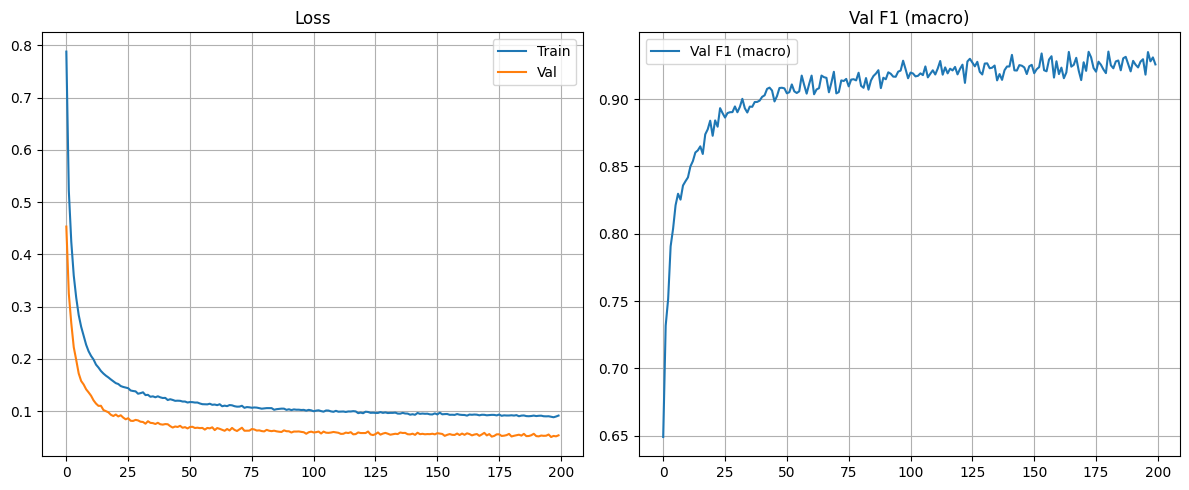

✓ Learned temperature on validation: T = 0.611

📊 Validation Classification Report
               precision    recall  f1-score   support

      oestrus       0.79      0.97      0.87      3599
      calving       0.98      1.00      0.99      3731
     lameness       0.97      1.00      0.99      3729
     mastitis       0.98      1.00      0.99      3727
other_disease       0.96      1.00      0.98      3713
           OK       0.96      0.60      0.74      3208

     accuracy                           0.94     21707
    macro avg       0.94      0.93      0.93     21707
 weighted avg       0.94      0.94      0.93     21707



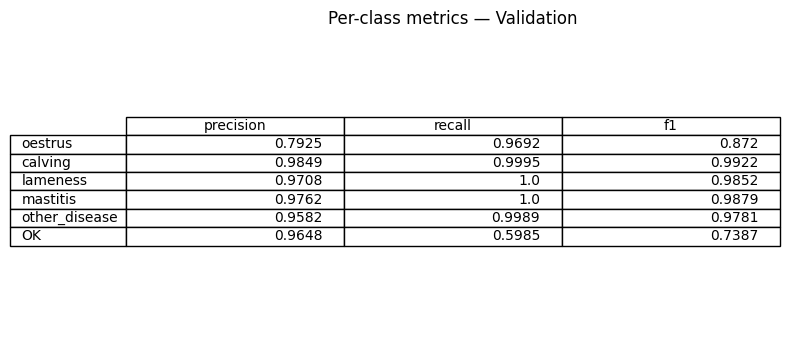

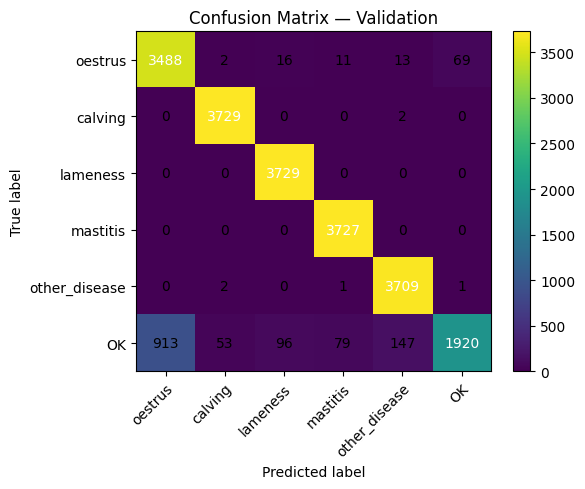


Summary:
  Accuracy      : 0.9353
  F1 (macro)    : 0.9257
  F1 (weighted) : 0.9305
Unique predicted classes on VALIDATION: [0 1 2 3 4 5]

[One-hot distribution (argmax, raw)]
OK               1782
calving          2072
lameness         2072
mastitis         2071
oestrus          2000
other_disease    2063
Name: count, dtype: int64
[One-hot sanity] all_zero=0, multi_hot=0, any_nan=0

📊 Holdout Classification Report
               precision    recall  f1-score   support

      oestrus       0.79      0.97      0.87      2000
      calving       0.99      1.00      1.00      2072
     lameness       0.97      1.00      0.98      2072
     mastitis       0.98      1.00      0.99      2071
other_disease       0.96      1.00      0.98      2063
           OK       0.97      0.59      0.74      1782

     accuracy                           0.93     12060
    macro avg       0.94      0.93      0.93     12060
 weighted avg       0.94      0.93      0.93     12060



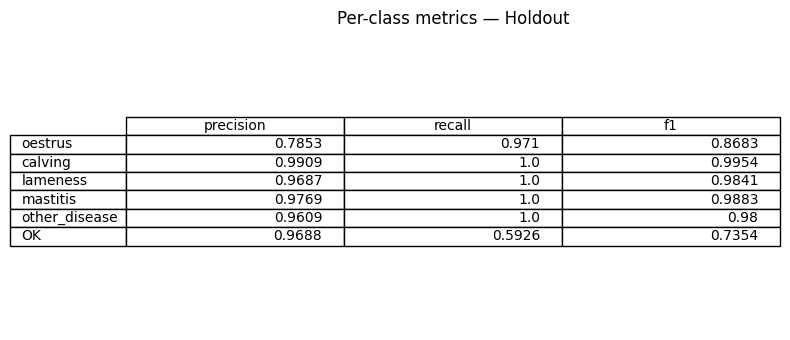

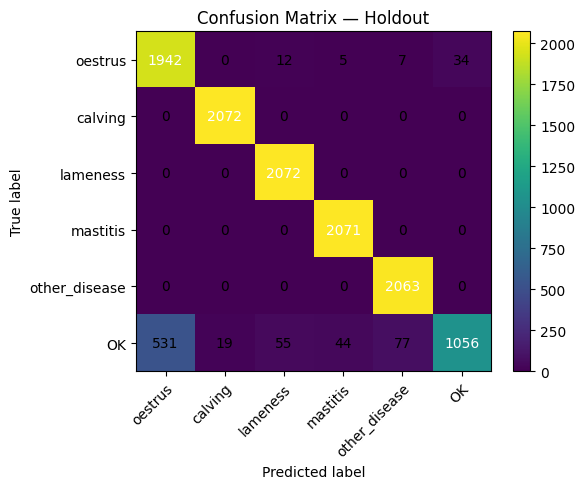


Summary:
  Accuracy      : 0.9350
  F1 (macro)    : 0.9253
  F1 (weighted) : 0.9301
Unique predicted classes on HOLDOUT: [0 1 2 3 4 5]


In [2]:
# Paths (edit as needed)
TRAINVAL_PATH = Path("augmented_dataset1_trainval.csv")
HOLDOUT_PATH  = Path("augmented_dataset1_holdout.csv")

# (Optional) Override global config here if you want
INCLUDE_CALVING = True
PREFER_TARGET_COLUMN = True
ALL_ZERO_POLICY = "drop"
NAN_POLICY = "drop"

SEED = 42
VAL_SIZE = 0.2

HIDDEN_DIMS = [512, 256, 128]
DROPOUTS    = [0.5, 0.4, 0.3]
ACTIVATION  = 'leakyrelu'
USE_BN      = True

BATCH_SIZE   = 128
LR           = 5e-4
WEIGHT_DECAY = 1e-4
EPOCHS       = 200
PATIENCE     = 30
MIN_DELTA    = 1e-3
USE_FOCAL    = True
LEARN_TEMP   = True

# ------------------------ Run ------------------------
set_seed(SEED)

FULL_LABELS, IDX2NAME, NAME2IDX = freeze_label_order(include_calving=INCLUDE_CALVING)

df_trainval = pd.read_csv(TRAINVAL_PATH)
df_holdout  = pd.read_csv(HOLDOUT_PATH)

df_trainval = optionally_drop_calving(df_trainval, INCLUDE_CALVING)
df_holdout  = optionally_drop_calving(df_holdout,  INCLUDE_CALVING)

drop_cols = ['cow','duration_hours']
if 'calving' in df_trainval.columns and 'calving' not in drop_cols:
    drop_cols.append('calving')  # exclude the one-hot/source column from features

# ---- Train and capture VALIDATION arrays for symmetric evaluation ----
model, scaler, T, feature_names, (X_val_arr, y_val_arr) = train_on_trainval(
    df_trainval,
    label_cols=FULL_LABELS,
    drop_cols=drop_cols,
    hidden_dims=HIDDEN_DIMS,
    dropout_rates=DROPOUTS,
    activation=ACTIVATION,
    use_batchnorm=USE_BN,
    batch_size=BATCH_SIZE,
    lr=LR,
    weight_decay=WEIGHT_DECAY,
    epochs=EPOCHS,
    patience=PATIENCE,
    min_delta=MIN_DELTA,
    use_focal_loss=USE_FOCAL,
    learn_temp=LEARN_TEMP,
    seed=SEED,
    val_size=VAL_SIZE
)

# ===== Validation results (same format as holdout) =====
_ = evaluate_on_arrays(
    model, X_val_arr, y_val_arr,
    class_names=FULL_LABELS,
    temperature=T,
    batch_size=BATCH_SIZE,
    title="Validation"
)

# ===== Holdout results =====
_ = evaluate_on_holdout(
    model, scaler, df_holdout,
    label_cols=FULL_LABELS,
    drop_cols=drop_cols,
    feature_names=feature_names,
    temperature=T,
    batch_size=BATCH_SIZE
)


[INFO] Removed 0 rows with calving==1 for 5-class setup.
[INFO] Removed 0 rows with calving==1 for 5-class setup.

[One-hot distribution (argmax, raw)]
OK                30786
lameness          34135
mastitis          35469
oestrus          207713
other_disease     34980
Name: count, dtype: int64
[One-hot sanity] all_zero=172516, multi_hot=0, any_nan=0
[INFO] Dropped 172516 rows with all-zero labels.


Training:  68%|██████▊   | 137/200 [21:26<09:51,  9.39s/it]


Early stopping at epoch 138


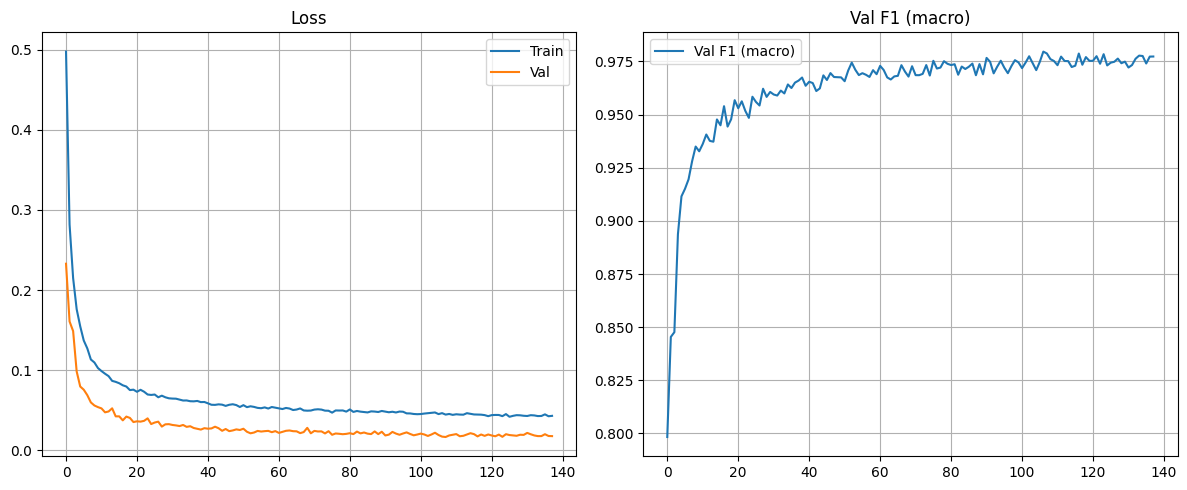

✓ Learned temperature on validation: T = 0.589

📊 Validation Classification Report
               precision    recall  f1-score   support

      oestrus       0.97      1.00      0.99      7040
     lameness       0.95      1.00      0.97      6827
     mastitis       1.00      1.00      1.00      7094
other_disease       0.98      1.00      0.99      6996
           OK       1.00      0.88      0.94      6157

     accuracy                           0.98     34114
    macro avg       0.98      0.98      0.98     34114
 weighted avg       0.98      0.98      0.98     34114



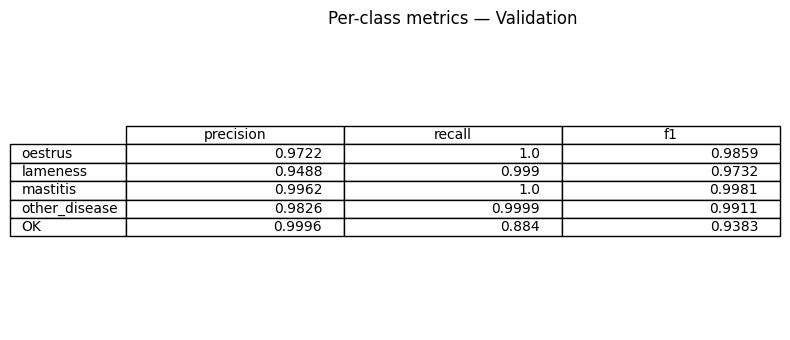

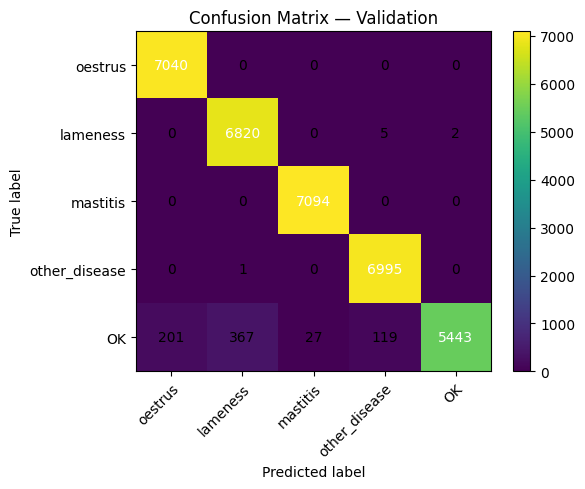


Summary:
  Accuracy      : 0.9788
  F1 (macro)    : 0.9773
  F1 (weighted) : 0.9784
Unique predicted classes on VALIDATION: [0 1 2 3 4]

[One-hot distribution (argmax, raw)]
OK                30786
lameness          34135
mastitis          35469
oestrus          207713
other_disease     34980
Name: count, dtype: int64
[One-hot sanity] all_zero=172516, multi_hot=0, any_nan=0
[INFO] Dropped 172516 rows with all-zero labels.

📊 Holdout Classification Report
               precision    recall  f1-score   support

      oestrus       0.98      1.00      0.99     35197
     lameness       0.95      1.00      0.98     34135
     mastitis       1.00      1.00      1.00     35469
other_disease       0.99      1.00      0.99     34980
           OK       1.00      0.90      0.95     30786

     accuracy                           0.98    170567
    macro avg       0.98      0.98      0.98    170567
 weighted avg       0.98      0.98      0.98    170567



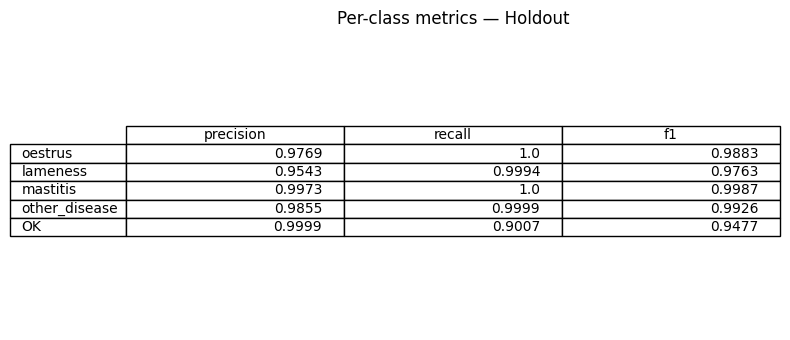

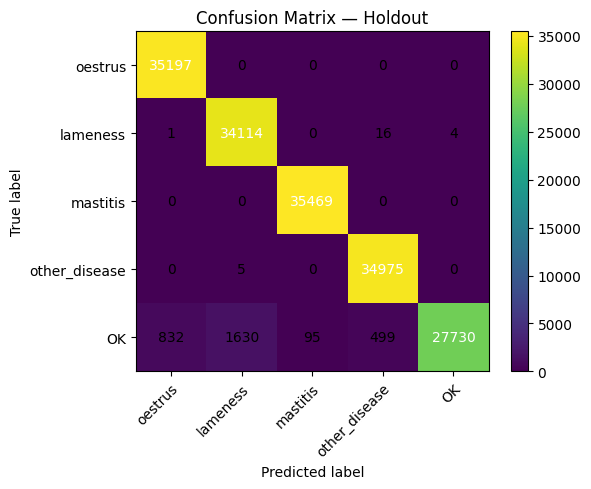


Summary:
  Accuracy      : 0.9819
  F1 (macro)    : 0.9807
  F1 (weighted) : 0.9816
Unique predicted classes on HOLDOUT: [0 1 2 3 4]


In [3]:
# ========= Paths for your new dataset =========
TRAINVAL_PATH = Path("augmented_dataset2_trainval.csv")
HOLDOUT_PATH  = Path("augmented_dataset2_trainval.csv")

# ========= Custom labels (EDIT THIS) =========
# Example A (no calving):
CUSTOM_LABELS = ['oestrus', 'lameness', 'mastitis', 'other_disease', 'OK']
INCLUDE_CALVING = False

# Example B (with calving) — comment the above and uncomment next two lines:
# CUSTOM_LABELS = ['oestrus', 'calving', 'lameness', 'mastitis', 'other_disease', 'OK']
# INCLUDE_CALVING = True

# ========= Other settings (adjust as needed) =========
PREFER_TARGET_COLUMN = True   # will use df['target'] if valid 0..C-1
ALL_ZERO_POLICY = "drop"
NAN_POLICY = "drop"

SEED = 42
VAL_SIZE = 0.2

HIDDEN_DIMS = [512, 256, 128]
DROPOUTS    = [0.5, 0.4, 0.3]
ACTIVATION  = 'leakyrelu'
USE_BN      = True

BATCH_SIZE   = 128
LR           = 5e-4
WEIGHT_DECAY = 1e-4
EPOCHS       = 200
PATIENCE     = 30
MIN_DELTA    = 1e-3
USE_FOCAL    = True
LEARN_TEMP   = True

# ==================== Run ====================
set_seed(SEED)

# Use your custom labels explicitly
FULL_LABELS, IDX2NAME, NAME2IDX = freeze_label_order(
    include_calving=INCLUDE_CALVING,
    custom_labels=CUSTOM_LABELS
)

df_trainval = pd.read_csv(TRAINVAL_PATH)
df_holdout  = pd.read_csv(HOLDOUT_PATH)

# If you're excluding calving, rows with calving==1 will be dropped (if that column exists)
df_trainval = optionally_drop_calving(df_trainval, INCLUDE_CALVING)
df_holdout  = optionally_drop_calving(df_holdout,  INCLUDE_CALVING)

# Feature drops: add any metadata columns here (and avoid leaking one-hot label columns)
drop_cols = ['cow','duration_hours']
# (DO NOT add your label columns here; they’re removed automatically downstream)
# If your dataset has extra non-feature columns, add them, e.g.:
# drop_cols += ['start_time', 'end_time', 'session_id']

# ---- Train and capture VALIDATION arrays for symmetric evaluation ----
model, scaler, T, feature_names, (X_val_arr, y_val_arr) = train_on_trainval(
    df_trainval,
    label_cols=FULL_LABELS,
    drop_cols=drop_cols,
    hidden_dims=HIDDEN_DIMS,
    dropout_rates=DROPOUTS,
    activation=ACTIVATION,
    use_batchnorm=USE_BN,
    batch_size=BATCH_SIZE,
    lr=LR,
    weight_decay=WEIGHT_DECAY,
    epochs=EPOCHS,
    patience=PATIENCE,
    min_delta=MIN_DELTA,
    use_focal_loss=USE_FOCAL,
    learn_temp=LEARN_TEMP,
    seed=SEED,
    val_size=VAL_SIZE
)

# ===== Validation results (same format as holdout) =====
_ = evaluate_on_arrays(
    model, X_val_arr, y_val_arr,
    class_names=FULL_LABELS,
    temperature=T,
    batch_size=BATCH_SIZE,
    title="Validation"
)

# ===== Holdout results =====
_ = evaluate_on_holdout(
    model, scaler, df_holdout,
    label_cols=FULL_LABELS,
    drop_cols=drop_cols,
    feature_names=feature_names,
    temperature=T,
    batch_size=BATCH_SIZE
)



[One-hot distribution (argmax, raw)]
OK         20697
oestrus    20635
Name: count, dtype: int64
[One-hot sanity] all_zero=0, multi_hot=0, any_nan=0


Training: 100%|██████████| 200/200 [07:35<00:00,  2.28s/it]


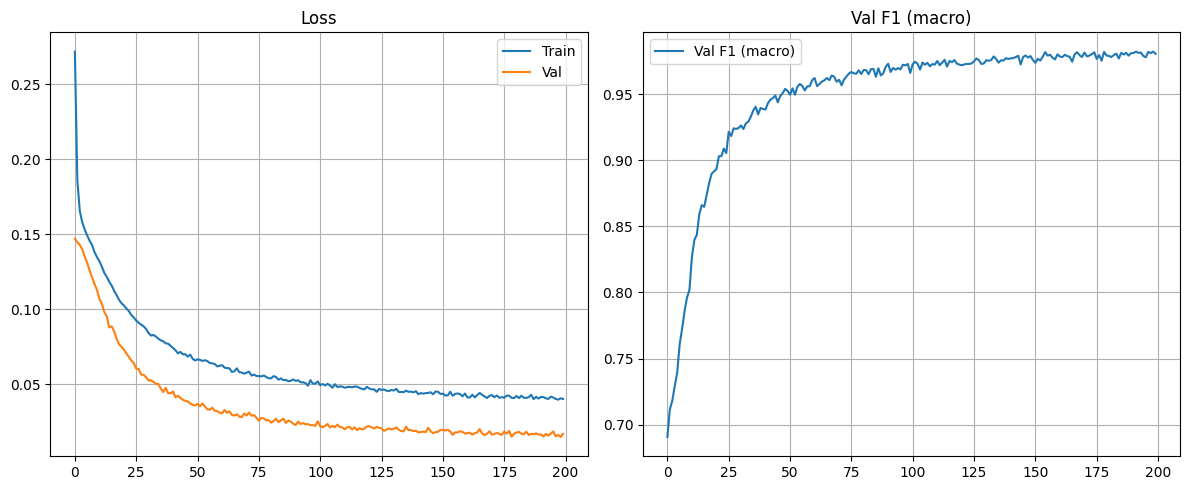

✓ Learned temperature on validation: T = 0.523

📊 Validation Classification Report
              precision    recall  f1-score   support

     oestrus       0.97      1.00      0.98      4127
          OK       1.00      0.96      0.98      4140

    accuracy                           0.98      8267
   macro avg       0.98      0.98      0.98      8267
weighted avg       0.98      0.98      0.98      8267



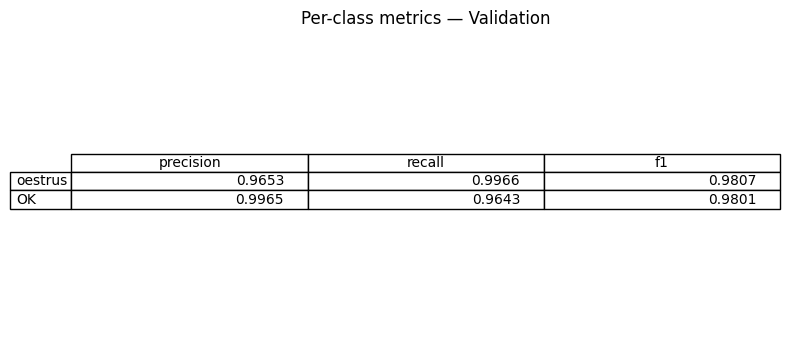

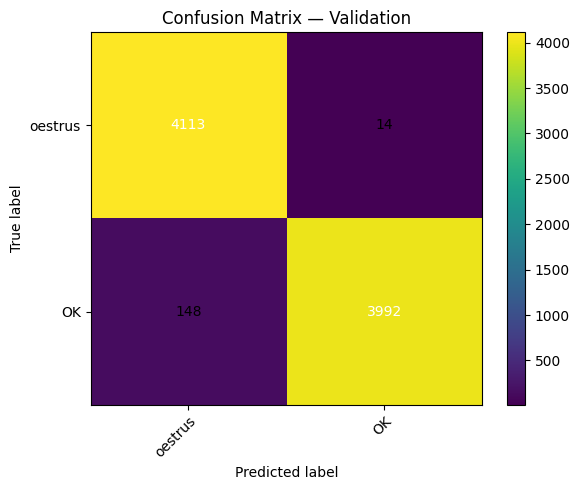


Summary:
  Accuracy      : 0.9804
  F1 (macro)    : 0.9804
  F1 (weighted) : 0.9804
Unique predicted classes on VALIDATION: [0 1]

[One-hot distribution (argmax, raw)]
OK         20697
oestrus    20635
Name: count, dtype: int64
[One-hot sanity] all_zero=0, multi_hot=0, any_nan=0

📊 Holdout Classification Report
              precision    recall  f1-score   support

     oestrus       0.98      1.00      0.99     20635
          OK       1.00      0.98      0.99     20697

    accuracy                           0.99     41332
   macro avg       0.99      0.99      0.99     41332
weighted avg       0.99      0.99      0.99     41332



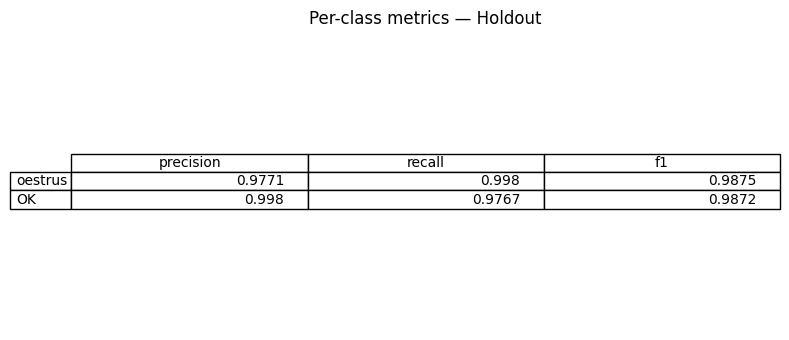

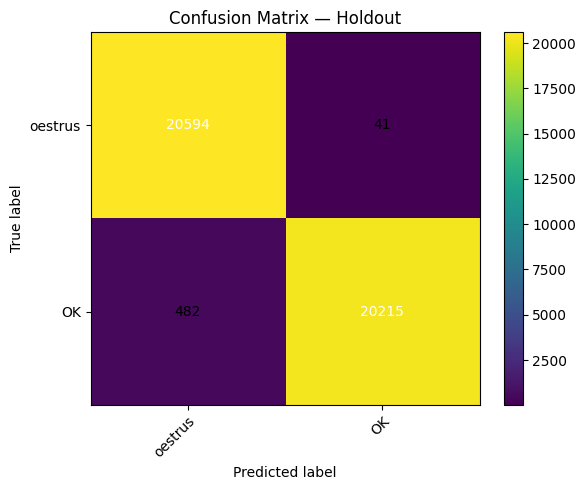


Summary:
  Accuracy      : 0.9873
  F1 (macro)    : 0.9873
  F1 (weighted) : 0.9873
Unique predicted classes on HOLDOUT: [0 1]


In [4]:
# ========= Paths for your new dataset =========
TRAINVAL_PATH = Path("augmented_dataset3_trainval.csv")
HOLDOUT_PATH  = Path("augmented_dataset3_trainval.csv")

# ========= Custom labels (EDIT THIS) =========
# Example A (no calving):
CUSTOM_LABELS = ['oestrus','OK']
INCLUDE_CALVING = False

# Example B (with calving) — comment the above and uncomment next two lines:
# CUSTOM_LABELS = ['oestrus', 'calving', 'lameness', 'mastitis', 'other_disease', 'OK']
# INCLUDE_CALVING = True

# ========= Other settings (adjust as needed) =========
PREFER_TARGET_COLUMN = True   # will use df['target'] if valid 0..C-1
ALL_ZERO_POLICY = "drop"
NAN_POLICY = "drop"

SEED = 42
VAL_SIZE = 0.2

HIDDEN_DIMS = [512, 256, 128]
DROPOUTS    = [0.5, 0.4, 0.3]
ACTIVATION  = 'leakyrelu'
USE_BN      = True

BATCH_SIZE   = 128
LR           = 5e-4
WEIGHT_DECAY = 1e-4
EPOCHS       = 200
PATIENCE     = 30
MIN_DELTA    = 1e-3
USE_FOCAL    = True
LEARN_TEMP   = True

# ==================== Run ====================
set_seed(SEED)

# Use your custom labels explicitly
FULL_LABELS, IDX2NAME, NAME2IDX = freeze_label_order(
    include_calving=INCLUDE_CALVING,
    custom_labels=CUSTOM_LABELS
)

df_trainval = pd.read_csv(TRAINVAL_PATH)
df_holdout  = pd.read_csv(HOLDOUT_PATH)

# If you're excluding calving, rows with calving==1 will be dropped (if that column exists)
df_trainval = optionally_drop_calving(df_trainval, INCLUDE_CALVING)
df_holdout  = optionally_drop_calving(df_holdout,  INCLUDE_CALVING)

# Feature drops: add any metadata columns here (and avoid leaking one-hot label columns)
drop_cols = ['cow','duration_hours']
# (DO NOT add your label columns here; they’re removed automatically downstream)
# If your dataset has extra non-feature columns, add them, e.g.:
# drop_cols += ['start_time', 'end_time', 'session_id']

# ---- Train and capture VALIDATION arrays for symmetric evaluation ----
model, scaler, T, feature_names, (X_val_arr, y_val_arr) = train_on_trainval(
    df_trainval,
    label_cols=FULL_LABELS,
    drop_cols=drop_cols,
    hidden_dims=HIDDEN_DIMS,
    dropout_rates=DROPOUTS,
    activation=ACTIVATION,
    use_batchnorm=USE_BN,
    batch_size=BATCH_SIZE,
    lr=LR,
    weight_decay=WEIGHT_DECAY,
    epochs=EPOCHS,
    patience=PATIENCE,
    min_delta=MIN_DELTA,
    use_focal_loss=USE_FOCAL,
    learn_temp=LEARN_TEMP,
    seed=SEED,
    val_size=VAL_SIZE
)

# ===== Validation results (same format as holdout) =====
_ = evaluate_on_arrays(
    model, X_val_arr, y_val_arr,
    class_names=FULL_LABELS,
    temperature=T,
    batch_size=BATCH_SIZE,
    title="Validation"
)

# ===== Holdout results =====
_ = evaluate_on_holdout(
    model, scaler, df_holdout,
    label_cols=FULL_LABELS,
    drop_cols=drop_cols,
    feature_names=feature_names,
    temperature=T,
    batch_size=BATCH_SIZE
)



[One-hot distribution (argmax, raw)]
OK               15688
calving          15704
lameness         15683
mastitis         15688
oestrus          15686
other_disease    15677
Name: count, dtype: int64
[One-hot sanity] all_zero=0, multi_hot=0, any_nan=0


Training:  96%|█████████▌| 191/200 [16:25<00:46,  5.16s/it]


Early stopping at epoch 192


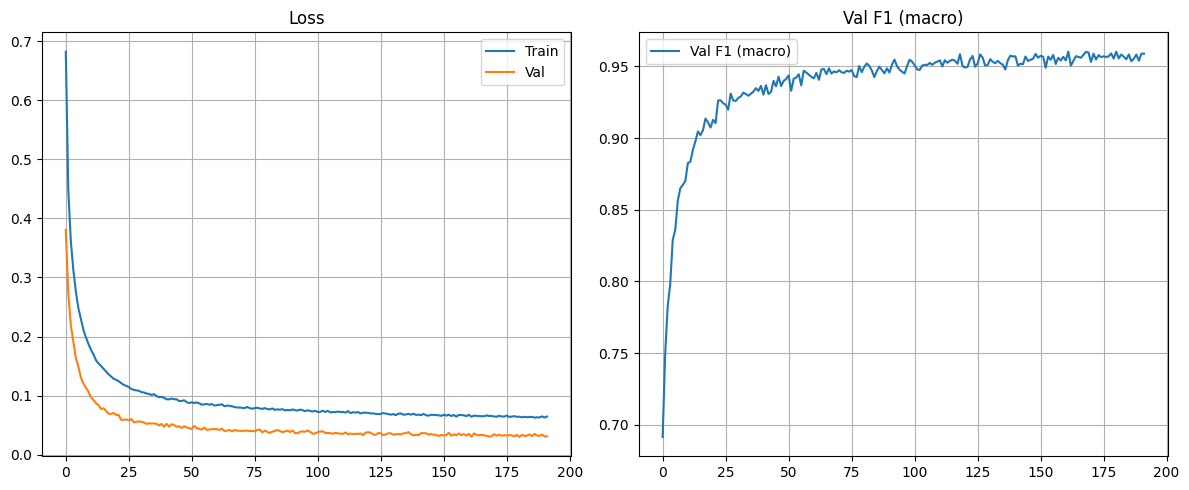

✓ Learned temperature on validation: T = 0.574

📊 Validation Classification Report
               precision    recall  f1-score   support

      oestrus       0.90      1.00      0.95      3137
      calving       0.98      1.00      0.99      3141
     lameness       0.94      1.00      0.97      3137
     mastitis       0.99      1.00      1.00      3138
other_disease       0.97      1.00      0.99      3135
           OK       1.00      0.77      0.87      3138

     accuracy                           0.96     18826
    macro avg       0.96      0.96      0.96     18826
 weighted avg       0.96      0.96      0.96     18826



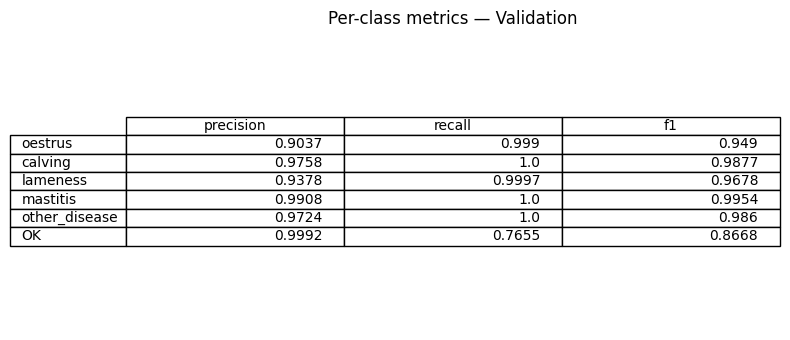

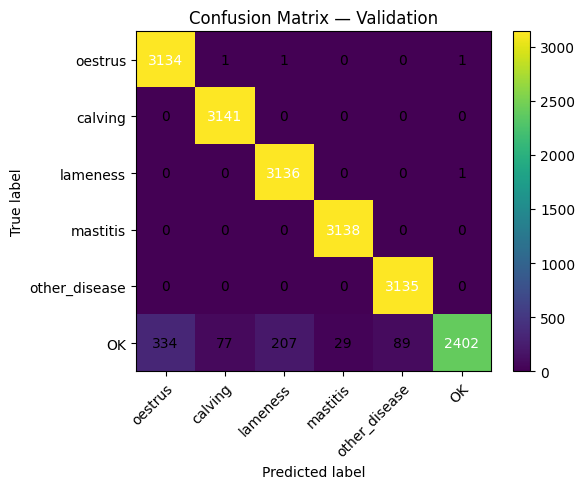


Summary:
  Accuracy      : 0.9607
  F1 (macro)    : 0.9588
  F1 (weighted) : 0.9588
Unique predicted classes on VALIDATION: [0 1 2 3 4 5]

[One-hot distribution (argmax, raw)]
OK               15688
calving          15704
lameness         15683
mastitis         15688
oestrus          15686
other_disease    15677
Name: count, dtype: int64
[One-hot sanity] all_zero=0, multi_hot=0, any_nan=0

📊 Holdout Classification Report
               precision    recall  f1-score   support

      oestrus       0.91      1.00      0.96     15686
      calving       0.97      1.00      0.99     15704
     lameness       0.95      1.00      0.97     15683
     mastitis       0.99      1.00      1.00     15688
other_disease       0.98      1.00      0.99     15677
           OK       1.00      0.79      0.89     15688

     accuracy                           0.97     94126
    macro avg       0.97      0.97      0.96     94126
 weighted avg       0.97      0.97      0.96     94126



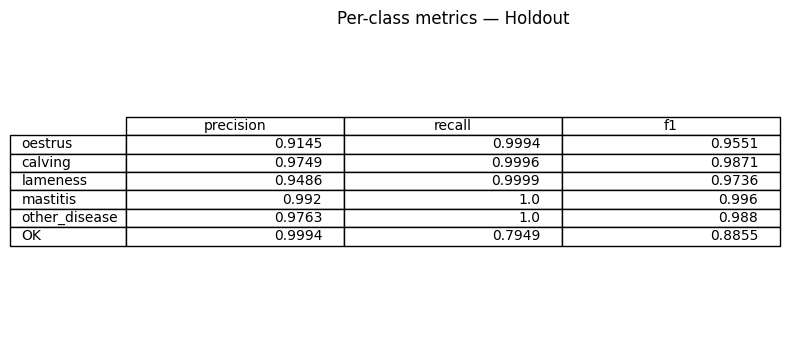

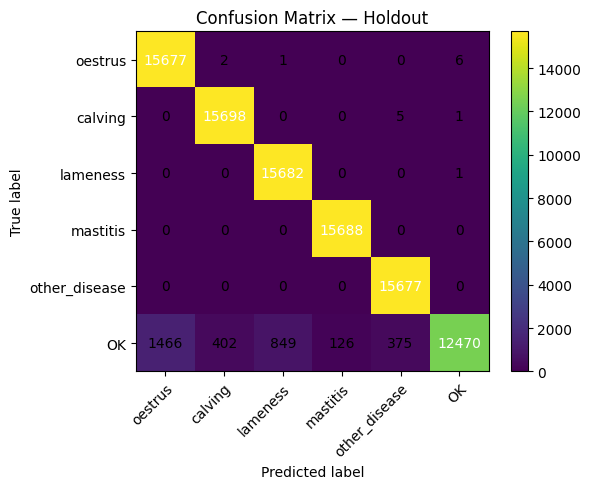


Summary:
  Accuracy      : 0.9656
  F1 (macro)    : 0.9642
  F1 (weighted) : 0.9642
Unique predicted classes on HOLDOUT: [0 1 2 3 4 5]


In [7]:
# ========= Paths for your new dataset =========
TRAINVAL_PATH = Path("augmented_dataset4_trainval.csv")
HOLDOUT_PATH  = Path("augmented_dataset4_trainval.csv")

# ========= Custom labels (EDIT THIS) =========


# Example B (with calving) — comment the above and uncomment next two lines:
CUSTOM_LABELS = ['oestrus', 'calving', 'lameness', 'mastitis', 'other_disease', 'OK']
INCLUDE_CALVING = True

# ========= Other settings (adjust as needed) =========
PREFER_TARGET_COLUMN = True   # will use df['target'] if valid 0..C-1
ALL_ZERO_POLICY = "drop"
NAN_POLICY = "drop"

SEED = 42
VAL_SIZE = 0.2

HIDDEN_DIMS = [512, 256, 128]
DROPOUTS    = [0.5, 0.4, 0.3]
ACTIVATION  = 'leakyrelu'
USE_BN      = True

BATCH_SIZE   = 128
LR           = 5e-4
WEIGHT_DECAY = 1e-4
EPOCHS       = 200
PATIENCE     = 30
MIN_DELTA    = 1e-3
USE_FOCAL    = True
LEARN_TEMP   = True

# ==================== Run ====================
set_seed(SEED)

# Use your custom labels explicitly
FULL_LABELS, IDX2NAME, NAME2IDX = freeze_label_order(
    include_calving=INCLUDE_CALVING,
    custom_labels=CUSTOM_LABELS
)

df_trainval = pd.read_csv(TRAINVAL_PATH)
df_holdout  = pd.read_csv(HOLDOUT_PATH)

# If you're excluding calving, rows with calving==1 will be dropped (if that column exists)
df_trainval = optionally_drop_calving(df_trainval, INCLUDE_CALVING)
df_holdout  = optionally_drop_calving(df_holdout,  INCLUDE_CALVING)

# Feature drops: add any metadata columns here (and avoid leaking one-hot label columns)
drop_cols = ['cow','duration_hours']
# (DO NOT add your label columns here; they’re removed automatically downstream)
# If your dataset has extra non-feature columns, add them, e.g.:
# drop_cols += ['start_time', 'end_time', 'session_id']

# ---- Train and capture VALIDATION arrays for symmetric evaluation ----
model, scaler, T, feature_names, (X_val_arr, y_val_arr) = train_on_trainval(
    df_trainval,
    label_cols=FULL_LABELS,
    drop_cols=drop_cols,
    hidden_dims=HIDDEN_DIMS,
    dropout_rates=DROPOUTS,
    activation=ACTIVATION,
    use_batchnorm=USE_BN,
    batch_size=BATCH_SIZE,
    lr=LR,
    weight_decay=WEIGHT_DECAY,
    epochs=EPOCHS,
    patience=PATIENCE,
    min_delta=MIN_DELTA,
    use_focal_loss=USE_FOCAL,
    learn_temp=LEARN_TEMP,
    seed=SEED,
    val_size=VAL_SIZE
)

# ===== Validation results (same format as holdout) =====
_ = evaluate_on_arrays(
    model, X_val_arr, y_val_arr,
    class_names=FULL_LABELS,
    temperature=T,
    batch_size=BATCH_SIZE,
    title="Validation"
)

# ===== Holdout results =====
_ = evaluate_on_holdout(
    model, scaler, df_holdout,
    label_cols=FULL_LABELS,
    drop_cols=drop_cols,
    feature_names=feature_names,
    temperature=T,
    batch_size=BATCH_SIZE
)
